In [220]:
from __future__ import print_function
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics, losses
from tensorflow.keras.datasets import mnist
from scipy.stats import norm
from tensorflow.python.keras.utils.vis_utils import plot_model
import collections
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [221]:
def load_dataset():
    #
    num_snaps = 20000
    tdiff = 9.0
    grid_dataset_list = []
    file_index = 1
    alphas = np.linspace(0.2, 0.8, 4)
    betas = np.linspace(0.2, 0.8, 4)
    
    for alpha in alphas:
        for beta in betas:
            if alpha != beta or (alpha > 0.5 and beta > 0.5):
                pair = (round(alpha, 2), round(beta, 2))
                grid_pt_data = pd.read_csv("RealTimeSnaps{}alpha{}beta{}tdiff{}.csv".format(num_snaps, pair[0], pair[1], tdiff), header=None)
                grid_pt_data['y'] = [file_index] * grid_pt_data.shape[0]
                grid_dataset_list.append(grid_pt_data)
                file_index += 1
    
    grid_dataset = pd.concat(grid_dataset_list)

    X = grid_dataset.iloc[:, :-1]
    y = grid_dataset.iloc[:, -1]
    
    return X, y

In [222]:
class VAE:
    
    def __init__(self, batch_size=100, original_dim = 100, intermediate_dim = 50, latent_dim = 3, epochs=50, epsilon=0.5):
        #
        self.batch_size = batch_size
        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.intermediate_dim = intermediate_dim
        self.epochs = epochs
        self.epsilon_std = epsilon
        
    def sampling(self, args):
        # Sampling from the latent variables using the means and log-variances
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], self.latent_dim), mean=0.,
                                  stddev=self.epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    
    def build(self):
        #
        original_dim = self.original_dim
        latent_dim = self.latent_dim
        intermediate_dim = self.intermediate_dim
        
        # encoder
        self.x = Input(shape=(original_dim,))
        h = Dense(intermediate_dim, activation='relu')(self.x)
        h2 = Dense(intermediate_dim/2, activation='relu')(h)
        h3 = Dense(intermediate_dim/4, activation='relu')(h2)
        self.z_mean = Dense(latent_dim)(h3)
        self.z_log_var = Dense(latent_dim)(h3)
        
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(self.sampling, output_shape=(latent_dim,))([self.z_mean, self.z_log_var])
        
        # we instantiate these layers separately so as to reuse them later
        decoder_h = Dense(intermediate_dim/4, activation='relu')
        decoder_h2 = Dense(intermediate_dim/2, activation='relu')
        decoder_h3 = Dense(intermediate_dim, activation='relu')
        decoder_mean = Dense(original_dim, activation='sigmoid')
        h_decoded = decoder_h(z)
        h2_decoded = decoder_h2(h_decoded)
        h3_decoded = decoder_h3(h2_decoded)
        x_decoded_mean = decoder_mean(h3_decoded)
        
        #decoder
        decoder_input = Input(shape=(latent_dim,))
        _h_decoded = decoder_h(decoder_input)
        _h2_decoded = decoder_h2(_h_decoded)
        _h3_decoded = decoder_h3(_h2_decoded)
        _x_decoded_mean = decoder_mean(_h3_decoded)
        
        self.generator = Model(decoder_input, _x_decoded_mean)

        
        # end-to-end VAE model
        self.vae = Model(self.x, x_decoded_mean)
        
        # encoder, from inputs to latent space
        self.encoder = Model(self.x, self.z_mean)
        plot_model(self.encoder, show_shapes=True)
        
        # decoder
        self.decoder = Model(decoder_input, _x_decoded_mean)
        plot_model(self.decoder, show_shapes=True)
        
        # Compute VAE loss
        self.vae.compile(optimizer='rmsprop', loss=self.vae_loss, metrics=['accuracy'])
        
        # Prints a summary of the architecture used
        self.vae.summary()

    def vae_loss(self, x, x_decoded_mean):
        #
        xent_loss = losses.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + self.z_log_var - K.square(self.z_mean) - K.exp(self.z_log_var), axis=-1)
        return xent_loss + kl_loss
    
    def train(self, x_train, x_test):
        #
        #x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) # flatten each sample out 
        #x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
        #x_train = minmax_scale(x_train) # this step is required in order to use cross-entropy loss for reconstruction
        #x_test = minmax_scale(x_train) # scaling features in 0,1 interval
        
        
        return self.vae.fit(x_train, x_train,
                shuffle=True,
                epochs=self.epochs,
                batch_size=self.batch_size,
                validation_data=(x_test, x_test)
                )

        # build a model to project inputs on the latent space
        #encoder = Model(self.x, self.z_mean)

    def predict_latent(self, xnew):
        # build a model to project inputs on the latent space
        return self.encoder.predict(xnew)
    
    def generate_decoding(self, znew):
        # Generate new fantasy particles 
        return self.generator.predict(znew)

In [223]:
X, y = load_dataset()

In [224]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.8)
print(xtrain.shape)

(56000, 100)


In [225]:
model = VAE(batch_size = 100, epochs=20, latent_dim=2, epsilon=0.01) # Choose model parameters
model.build() # Construct VAE model using Keras
vae_history = model.train(xtrain, xtest) # Trains VAE model based on custom loss function

Model: "model_63"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense_164 (Dense)               (None, 50)           5050        input_41[0][0]                   
__________________________________________________________________________________________________
dense_165 (Dense)               (None, 25)           1275        dense_164[0][0]                  
__________________________________________________________________________________________________
dense_166 (Dense)               (None, 12)           312         dense_165[0][0]                  
___________________________________________________________________________________________

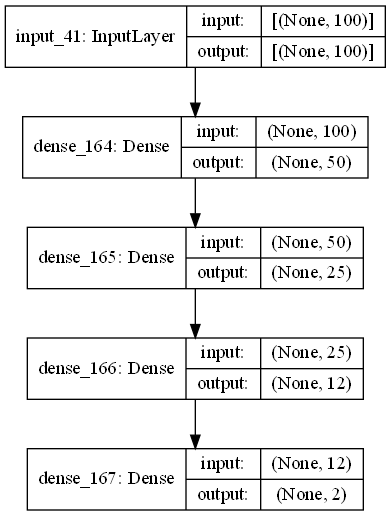

In [226]:
plot_model(model.encoder, show_shapes=True)

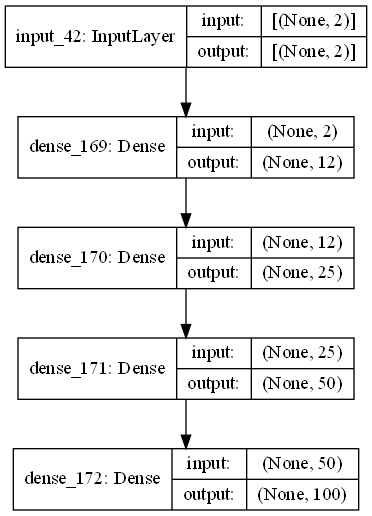

In [227]:
plot_model(model.decoder, show_shapes=True)

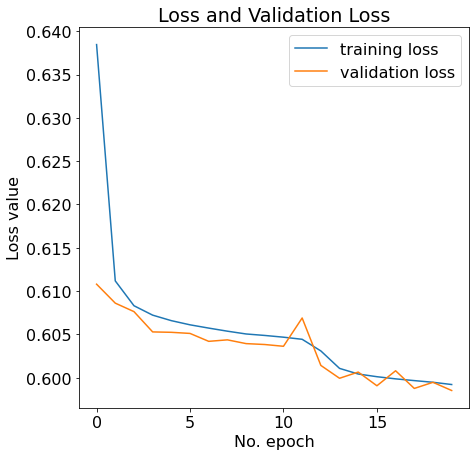

In [228]:
plt.figure(figsize=(7, 7))
plt.plot(vae_history.history['loss'], label='training loss')
plt.plot(vae_history.history['val_loss'], label='validation loss')
plt.title('Loss and Validation Loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

In [229]:
zpred = model.predict_latent(xtest)
print(zpred.shape)

(224000, 2)


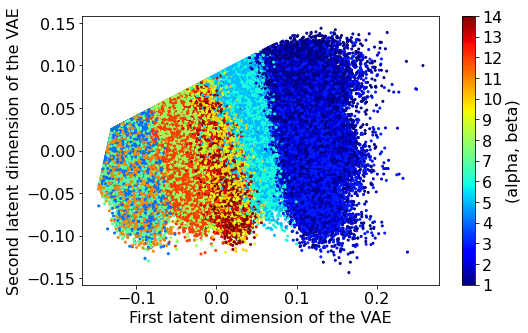

In [230]:
# To make plots pretty
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

plt.rc('font',**{'size':16})
fig, ax = plt.subplots(1,figsize=golden_size(8))
sc = ax.scatter(zpred[:,0], zpred[:,1], c=ytest, s=4, cmap="jet")
ax.set_xlabel('First latent dimension of the VAE')
ax.set_ylabel('Second latent dimension of the VAE')
#plt.colorbar(sc, label='(alpha, beta)')
cbar = plt.colorbar(sc, label='(alpha, beta)')
cbar.ax.locator_params(nbins=14)
#plt.savefig('latent_plot.png')
plt.show()

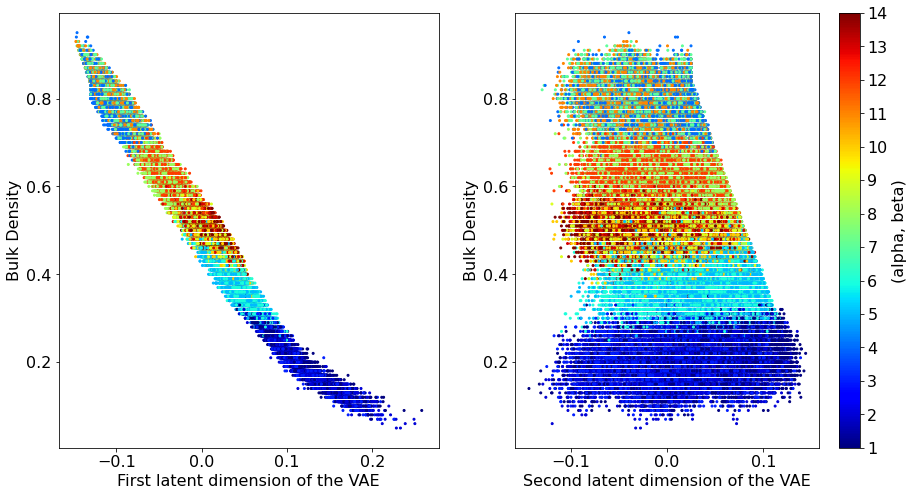

In [231]:
plt.rc('font',**{'size':16})
fig, ax = plt.subplots(1,2,figsize=(15,8))
ax[0].scatter(zpred[:,0], np.mean(xtest, axis=1), c=ytest, s=4, cmap="jet")
ax[0].set_xlabel('First latent dimension of the VAE')
ax[0].set_ylabel('Bulk Density')
sc = ax[1].scatter(zpred[:,1], np.mean(xtest, axis=1), c=ytest, s=4, cmap="jet")
ax[1].set_xlabel('Second latent dimension of the VAE')
ax[1].set_ylabel('Bulk Density')
cbar = plt.colorbar(sc, label='(alpha, beta)')
cbar.ax.locator_params(nbins=14)
#plt.savefig('Latent_Density.png')
plt.show()

In [232]:
xtest_currents = []
for i in range(len(xtest)):
    jumps_possible = 0
    occs = np.array(xtest.iloc[i])
    for j in range(len(occs)): 
        if  j == len(occs)-1 and occs[j] == 1:
            jumps_possible += 1
        elif occs[j] == 1 and occs[j+1] == 0:
            jumps_possible += 1
    xtest_currents.append(jumps_possible / len(occs))

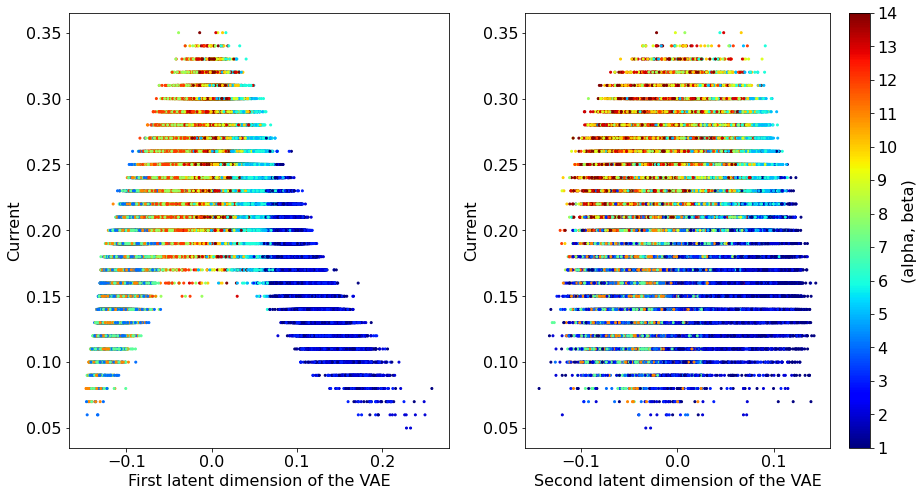

In [233]:
plt.rc('font',**{'size':16})
fig, ax = plt.subplots(1,2,figsize=(15,8))
ax[0].scatter(zpred[:,0], xtest_currents, c=ytest, s=4, cmap="jet")
ax[0].set_xlabel('First latent dimension of the VAE')
ax[0].set_ylabel('Current')
sc = ax[1].scatter(zpred[:,1], xtest_currents, c=ytest, s=4, cmap="jet")
ax[1].set_xlabel('Second latent dimension of the VAE')
ax[1].set_ylabel('Current')
cbar = plt.colorbar(sc, label='(alpha, beta)')
cbar.ax.locator_params(nbins=14)
#plt.savefig('Latent_Current.png')
plt.show()

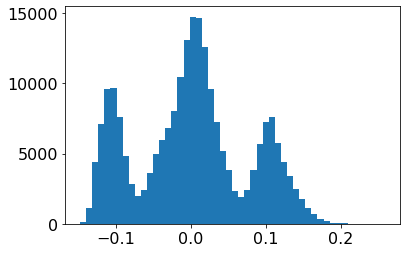

In [235]:
# Make histogram at the 
plt.hist(zpred[:,0],bins=50)
plt.show()